In [11]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [12]:
%matplotlib inline

In [13]:
from relaxed.plot_defaults import *

In [14]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [15]:
from relaxed.analysis import get_mah, add_box_indices, get_tt_indices
from relaxed.models import training_suite
from relaxed import halo_catalogs

# Data

In [90]:
mah_data = get_mah('m12', '../../../output/', cutoff_missing=0.90, cutoff_particle=0.90) # not strict

In [91]:
# catalog
cat = mah_data['cat']
xoff = cat['xoff']
cvir = cat['cvir']
eta = cat['eta']
ma = mah_data['ma']
am = mah_data['am']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(9990,) (9990,) (9990,) (9990, 100) (9990, 178) (178,) (100,)


In [92]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [93]:
# train/test split.
train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.3)

cat_train, am_train, cvir_train, xoff_train, eta_train =  (cat[train_idx], am[train_idx], cvir[train_idx], 
                                                          xoff[train_idx], eta[train_idx])
cat_test, am_test, cvir_test, xoff_test, eta_test = (cat[test_idx], am[test_idx], cvir[test_idx], 
                                                          xoff[test_idx], eta[test_idx], )

print(cvir_train.shape, cvir_test.shape)

(6993,) (2997,)


# Extract MM scales, make histogram

In [94]:
# first we need merger ratio at every scale 
merger_ratio  = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices):
#         f_sub_name = f'f_sub_a{idx}'
        m2_name = f'm2_a{idx}'
        cpgratio_name = f'cpgratio_a{idx}'
        merger_ratio[i, j] = np.nanmax([cat[m2_name][i], cat[cpgratio_name][i]])

<ipython-input-94-7bc4d1c9bdf8>:8: RuntimeWarning: All-NaN axis encountered
  merger_ratio[i, j] = np.nanmax([cat[m2_name][i], cat[cpgratio_name][i]])


In [95]:
# now construct scale of last MM (at present day) as a function fo different thresholds
# Mu = np.linspace(0.1, 1, num=10)
Mu = [1/3, 1/10, 1/30, 1/100]
cutoff_scales= [0.25, 0.3, 0.4, 0.8] # cutoffs for 50 particles (phil)
scale_of_last_MM = np.zeros((len(cat), len(Mu)))
for i in range(len(cat)):
    for k, mu in enumerate(Mu):
        MM_indices = np.where(merger_ratio[i] > mu)[0]
        if len(MM_indices) > 0 and scales[MM_indices[-1]] >= cutoff_scales[k]: 
            scale_of_last_MM[i, k] = scales[MM_indices[-1]]
        else: 
            scale_of_last_MM[i, k] = np.nan

(100, 10000)

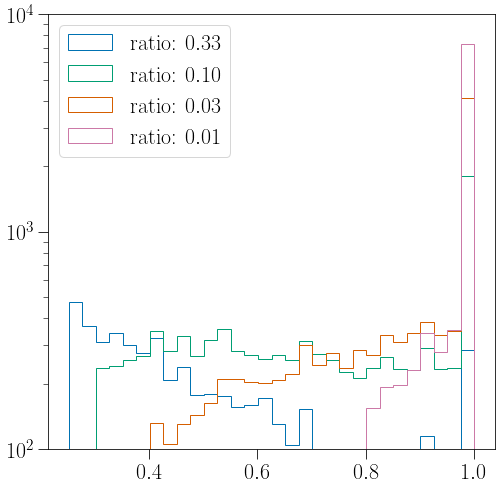

In [101]:
plt.figure(figsize=(8,8))
bins = get_bins(scale_of_last_MM[:, 0][~np.isnan(scale_of_last_MM[:, 0])], bins=30)
for k, cutoff in enumerate(cutoff_scales): 
    plt.hist(scale_of_last_MM[:, k], histtype='step', label=f'\\rm ratio: ${Mu[k]:.2f}$', bins=bins)
plt.legend(loc=2)
plt.yscale('log')
plt.ylim(10**2, 10**4)

In [82]:
[sum(np.isnan(scale_of_last_MM[:, k])) for k in range(4)]

[4483, 941, 304, 970]

In [81]:
sum(scale_of_last_MM[:, 1]> 0.8)

3525